В этой задаче по прогнозированию цен на жилье с использованием машинного обучения наша задача - использовать данные переписи населения Калифорнии для создания модели машинного обучения для прогнозирования цен на жилье в штате. Данные включают такие характеристики, как численность населения, средний доход и средние цены на жилье для каждой группы кварталов в Калифорнии.

Квартальные группы - это наименьшая географическая единица, население которой обычно составляет от 600 до 3000 человек. Для краткости мы можем называть их районами. В конечном счете, наша модель машинного обучения должна быть в состоянии предсказать среднюю цену на жилье в любом районе с учетом всех других показателей.

Методы регрессионного анализа могут помочь определить, какие из переменных наиболее сильно влияют на цену на жилье, и как они взаимодействуют друг с другом. 

In [905]:
#Зависимая переменная - median_house_value

In [906]:
import warnings
warnings.filterwarnings('ignore')
import statsmodels
import scipy as sc
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor




In [907]:
df_train=pd.read_csv('house.csv')


# оставим только колонки с числовыми значениями

In [908]:
numeric_features = df_train.select_dtypes(include=[np.number])
numeric_features = numeric_features.select_dtypes(include=['float'])
numeric_features =numeric_features.drop(['Rooms', 'HouseFloor'],  axis=1)

numeric_features.columns

Index(['Square', 'LifeSquare', 'KitchenSquare', 'Ecology_1', 'Healthcare_1',
       'Price'],
      dtype='object')

In [909]:
numeric_features

,Square,LifeSquare,KitchenSquare,Ecology_1,Healthcare_1,Price
0,47.981561,29.442751,6.0,0.089040,NaN,184966.930730
1,65.683640,40.049543,8.0,0.000070,240.0,300009.450063
2,44.947953,29.197612,0.0,0.049637,229.0,220925.908524
3,53.352981,52.731512,9.0,0.437885,1084.0,175616.227217
4,39.649192,23.776169,7.0,0.012339,2078.0,150226.531644
...,...,...,...,...,...,...
9995,50.401785,30.476203,5.0,0.135650,350.0,196684.316040
9996,41.521546,20.539216,9.0,0.000000,NaN,189050.289571
9997,47.939008,NaN,1.0,0.072158,NaN,159143.805370
9998,43.602562,33.840147,8.0,0.307467,325.0,181595.339808


# опишем переменные 

In [910]:
numeric_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Square         10000 non-null  float64
 1   LifeSquare     7887 non-null   float64
 2   KitchenSquare  10000 non-null  float64
 3   Ecology_1      10000 non-null  float64
 4   Healthcare_1   5202 non-null   float64
 5   Price          10000 non-null  float64
dtypes: float64(6)
memory usage: 468.9 KB


In [911]:
#Id - идентификационный номер квартиры
#DistrictId - идентификационный номер района
#Rooms - количество комнат
#Square - площадь
#LifeSquare - жилая площадь
#KitchenSquare - площадь кухни
#Floor - этаж
#HouseFloor - количество этажей в доме
#HouseYear - год постройки дома
#Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
#Social_1, Social_2, Social_3 - социальные показатели местности
#Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
#Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
#Price - цена квартиры 

In [912]:
# Теперь, поскольку мы будем предсказывать цену жилья, посмотрим описание этой колонки
numeric_features['Price'].describe()

count     10000.000000
mean     214138.857399
std       92872.293865
min       59174.778028
25%      153872.633942
50%      192269.644879
75%      249135.462171
max      633233.466570
Name: Price, dtype: float64

In [913]:
#построим диаграмму для каждого числового атрибута

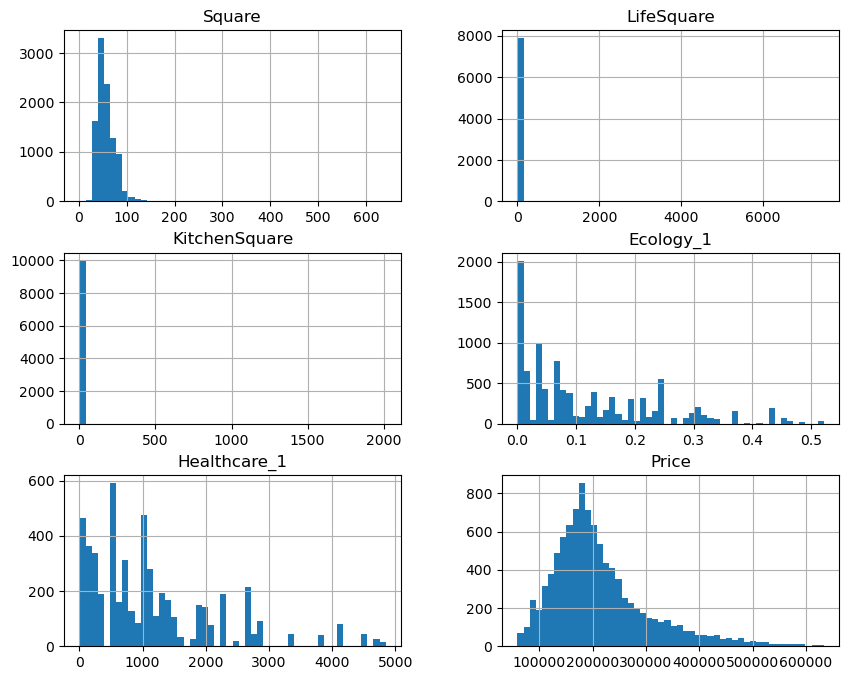

In [914]:
numeric_features.hist(bins=50, figsize=(10, 8))
plt.show()

# избавимся от выбросов

<Axes: >

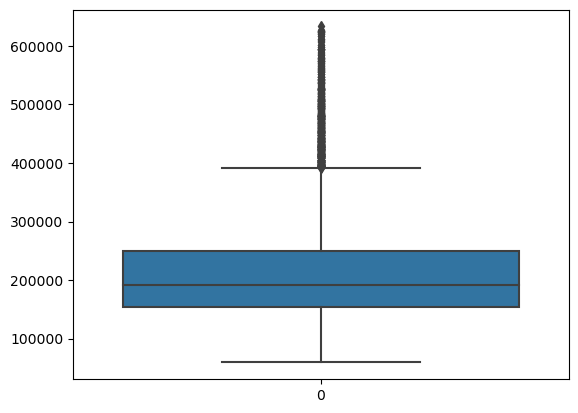

In [915]:
sns.boxplot(numeric_features['Price'])

In [916]:
q1 = numeric_features['Price'].quantile(0.25)
q3 = numeric_features['Price'].quantile(0.75)
iqr = q3 - q1
gran = 1.5 * iqr + q3
print(gran)

392029.7045148853


In [917]:
numeric_features = numeric_features[numeric_features['Price']<gran]

In [918]:
numeric_features['Price'].describe()

count      9417.000000
mean     198439.986670
std       68677.236826
min       59174.778028
25%      151028.428278
50%      187599.924231
75%      236647.781363
max      391982.648184
Name: Price, dtype: float64

<Axes: >

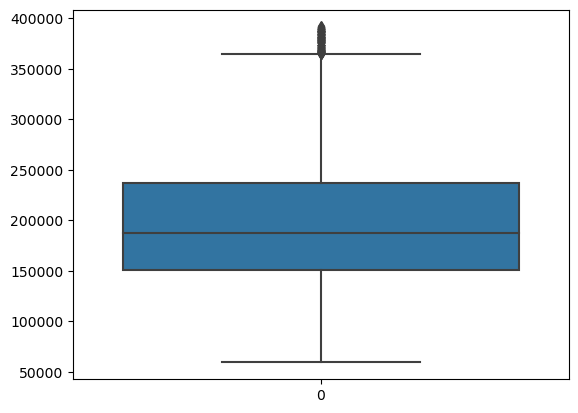

In [919]:
sns.boxplot(numeric_features['Price'])

In [920]:
#получили без выбросов


# Анализ коэффициентов вздутия дисперсии

In [921]:
X=numeric_features.drop(['Price'],  axis=1)


In [922]:

X

,Square,LifeSquare,KitchenSquare,Ecology_1,Healthcare_1
0,47.981561,29.442751,6.0,0.089040,NaN
1,65.683640,40.049543,8.0,0.000070,240.0
2,44.947953,29.197612,0.0,0.049637,229.0
3,53.352981,52.731512,9.0,0.437885,1084.0
4,39.649192,23.776169,7.0,0.012339,2078.0
...,...,...,...,...,...
9995,50.401785,30.476203,5.0,0.135650,350.0
9996,41.521546,20.539216,9.0,0.000000,NaN
9997,47.939008,NaN,1.0,0.072158,NaN
9998,43.602562,33.840147,8.0,0.307467,325.0


In [923]:
# УДАЛЯЕМ СТРОКИ С ПРОПУЩЕННЫМИ ЗНАЧЕНИЯМИ
X = X.dropna()
X

,Square,LifeSquare,KitchenSquare,Ecology_1,Healthcare_1
1,65.683640,40.049543,8.0,0.000070,240.0
2,44.947953,29.197612,0.0,0.049637,229.0
3,53.352981,52.731512,9.0,0.437885,1084.0
4,39.649192,23.776169,7.0,0.012339,2078.0
5,80.384479,46.683720,12.0,0.309479,990.0
...,...,...,...,...,...
9990,57.373889,39.688445,5.0,0.036270,200.0
9991,101.622794,51.628780,12.0,0.265089,1937.0
9995,50.401785,30.476203,5.0,0.135650,350.0
9998,43.602562,33.840147,8.0,0.307467,325.0


In [924]:

vif=pd.DataFrame()
vif['признак']=X.columns
vif['VIF']=[variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [925]:
vif

,признак,VIF
0,Square,16.762855
1,LifeSquare,13.883403
2,KitchenSquare,1.053275
3,Ecology_1,2.024160
4,Healthcare_1,1.979128


In [926]:
X.corr()

,Square,LifeSquare,KitchenSquare,Ecology_1,Healthcare_1
Square,1.000000,0.841837,0.009027,-0.001245,-0.068295
LifeSquare,0.841837,1.000000,-0.005984,0.021139,-0.054308
KitchenSquare,0.009027,-0.005984,1.000000,-0.023979,-0.006467
Ecology_1,-0.001245,0.021139,-0.023979,1.000000,-0.007977
Healthcare_1,-0.068295,-0.054308,-0.006467,-0.007977,1.000000


In [927]:
m1=smf.ols('Price~ Square+LifeSquare+KitchenSquare+'\
          'Ecology_1+Healthcare_1',
          data=numeric_features)
fitted=m1.fit()
print(fitted.summary())


                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     233.5
Date:                Thu, 09 Nov 2023   Prob (F-statistic):          8.08e-220
Time:                        20:51:58   Log-Likelihood:                -50723.
No. Observations:                4082   AIC:                         1.015e+05
Df Residuals:                    4076   BIC:                         1.015e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.288e+05   3330.782     38.659

In [928]:
np.sum((fitted.resid)**2)

14841951811054.67

In [929]:
#уберем Healthcare_1 и multicollinearity  пропадет
m1=smf.ols('Price~ Square+LifeSquare+KitchenSquare+'\
          'Ecology_1',
          data=numeric_features)
fitted=m1.fit()
print(fitted.summary())


                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     460.2
Date:                Thu, 09 Nov 2023   Prob (F-statistic):               0.00
Time:                        20:51:58   Log-Likelihood:                -91634.
No. Observations:                7356   AIC:                         1.833e+05
Df Residuals:                    7351   BIC:                         1.833e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.191e+05   2356.090     50.561

In [930]:
np.sum((fitted.resid)**2)

28458103749801.305

In [931]:
#уберем незначимую KitchenSquare
m1=smf.ols('Price~ Square+LifeSquare+'\
          'Ecology_1',
          data=numeric_features)
fitted=m1.fit()
print(fitted.summary())


                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     613.6
Date:                Thu, 09 Nov 2023   Prob (F-statistic):               0.00
Time:                        20:51:59   Log-Likelihood:                -91634.
No. Observations:                7356   AIC:                         1.833e+05
Df Residuals:                    7352   BIC:                         1.833e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.191e+05   2351.210     50.642      0.0

In [932]:
np.sum((fitted.resid)**2)

28458627366845.33

# анализ ошибок

In [933]:
fitted.ess

7125615406962.9375

In [934]:
fitted.centered_tss

35584242773808.266

In [935]:
R_sqd=fitted.ess/fitted.centered_tss
R_sqd

0.20024636894079806

In [937]:
fitted.fittedvalues

0       197825.580563
1       228607.815438
2       193290.739398
3       201446.984190
4       185025.760016
            ...      
9993    252258.839325
9995    201212.029138
9996    188411.559088
9998    187292.584957
9999    183602.593370
Length: 7356, dtype: float64

In [938]:
numeric_features.Price-fitted.fittedvalues

0      -12858.649833
1       71401.634624
2       27635.169126
3      -25830.756973
4      -34799.228372
            ...     
9995             NaN
9996             NaN
9997             NaN
9998             NaN
9999             NaN
Length: 9417, dtype: float64

In [939]:
fitted.resid

0      -12858.649833
1       71401.634624
2       27635.169126
3      -25830.756973
4      -34799.228372
            ...     
9993    98425.789236
9995    -4527.713097
9996      638.730484
9998    -5697.245149
9999    35111.484245
Length: 7356, dtype: float64

<Axes: >

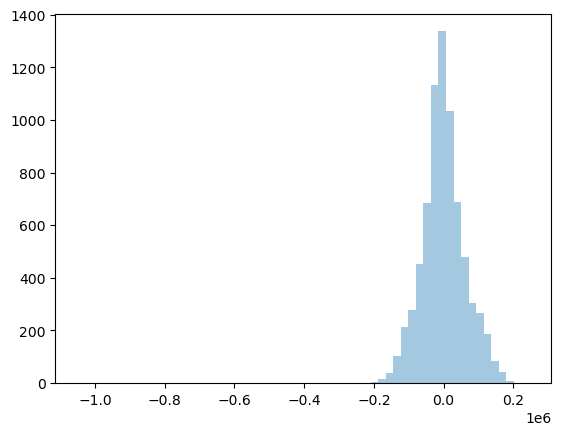

In [946]:
import seaborn as sns
sns.distplot(fitted.resid, kde=False, bins=60)

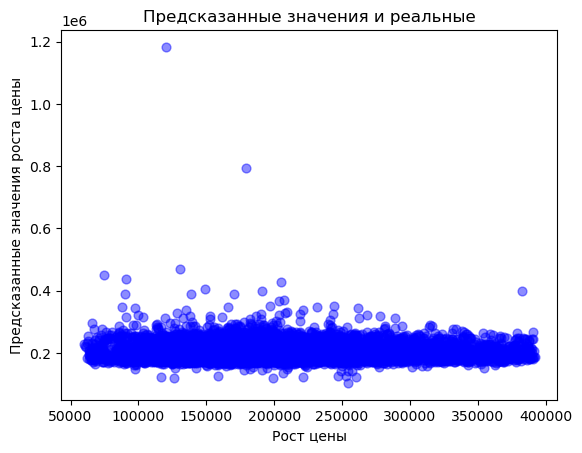

In [947]:
plt.scatter(numeric_features.Price.head(len(fitted.fittedvalues)), fitted.fittedvalues, color='blue', s=40, alpha=0.45)
plt.title('Предсказанные значения и реальные')
plt.xlabel('Рост цены')
plt.ylabel('Предсказанные значения роста цены')
plt.show()

In [ ]:
Предсказанные значения получились в виде облачка, что говорит о точности модели

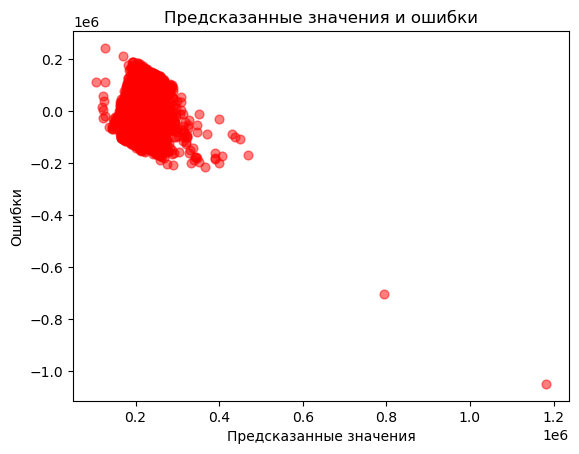

In [885]:
plt.scatter(fitted.fittedvalues, fitted.resid, color='red', s=40, alpha=0.5)
plt.title('Предсказанные значения и ошибки')
plt.xlabel('Предсказанные значения')
plt.ylabel('Ошибки')
plt.show()

In [ ]:
ошибки расположено около нуля, что говорит о точности модели

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


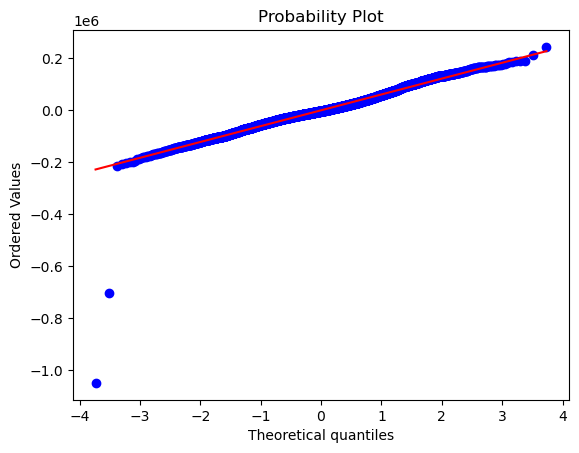

In [949]:
%pylab inline
sc.stats.probplot(fitted.resid, dist='norm', plot=pylab)
plt.show()

In [ ]:
значения лежат вдоль нормальной прямой, что говорит о точности модели

# логарифмируем цену

In [950]:
#уберем незначимую KitchenSquare
m1=smf.ols('np.log(Price)~ Square+LifeSquare+'\
          'Ecology_1',
          data=numeric_features)
fitted=m1.fit()
print(fitted.summary())


                            OLS Regression Results                            
Dep. Variable:          np.log(Price)   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     351.3
Date:                Thu, 09 Nov 2023   Prob (F-statistic):          1.62e-209
Time:                        21:04:24   Log-Likelihood:                -1622.3
No. Observations:                5765   AIC:                             3253.
Df Residuals:                    5761   BIC:                             3279.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.8049      0.013    877.789      0.0

<Axes: >

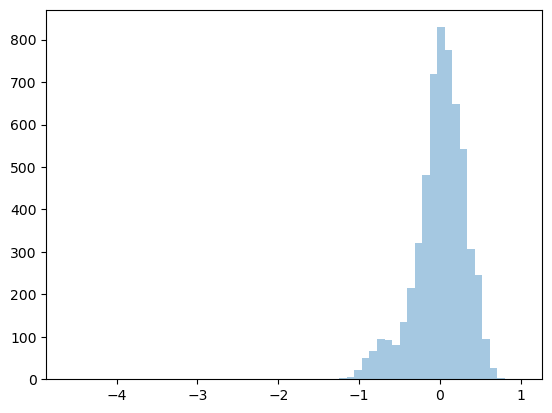

In [951]:
sns.distplot(fitted.resid, kde=False, bins=60)

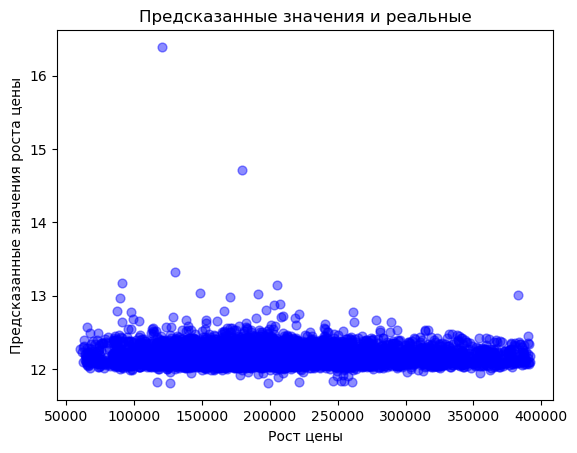

In [953]:
plt.scatter(numeric_features.Price.head(len(fitted.fittedvalues)), fitted.fittedvalues, color='blue', s=40, alpha=0.45)
plt.title('Предсказанные значения и реальные')
plt.xlabel('Рост цены')
plt.ylabel('Предсказанные значения роста цены')
plt.show()

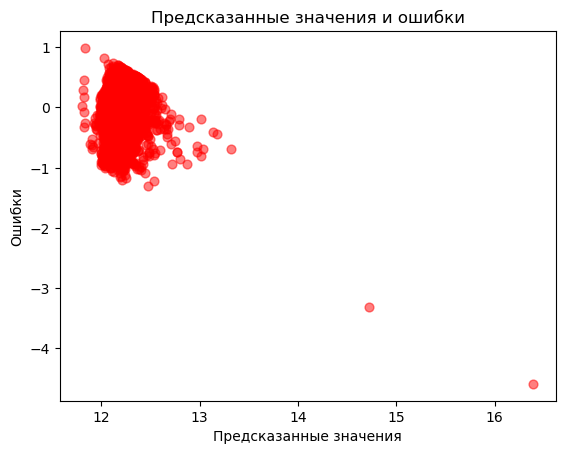

In [954]:
plt.scatter(fitted.fittedvalues, fitted.resid, color='red', s=40, alpha=0.5)
plt.title('Предсказанные значения и ошибки')
plt.xlabel('Предсказанные значения')
plt.ylabel('Ошибки')
plt.show()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


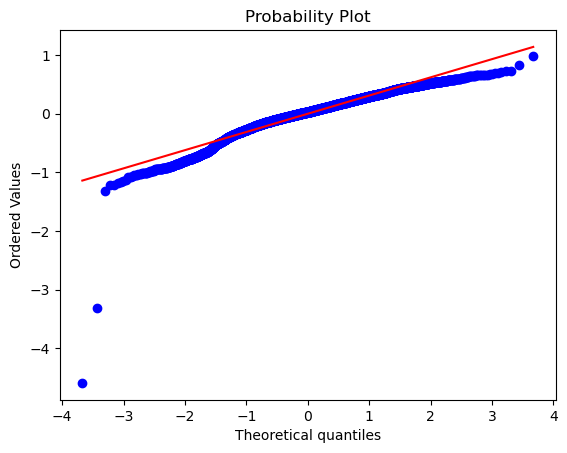

In [955]:
%pylab inline
sc.stats.probplot(fitted.resid, dist='norm', plot=pylab)
plt.show()

In [ ]:
вывод: модель без лагорифма была более точной

# Переход к нормированным данным

In [990]:
numeric_features= numeric_features.dropna()

In [991]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LassoCV

In [992]:
scaler = MinMaxScaler()
scaler.fit(numeric_features)
data_std=scaler.transform(numeric_features)

In [993]:
data_std

array([[9.88102858e-02, 6.22128960e-02, 7.14285714e-02, 1.52756869e-04,
        4.35775057e-02, 7.21615035e-01],
       [6.63330751e-02, 4.51980682e-02, 0.00000000e+00, 1.08337017e-01,
        4.12948745e-02, 4.80692805e-01],
       [7.94974271e-02, 8.20970559e-02, 8.03571429e-02, 9.55717207e-01,
        2.18717576e-01, 3.42660173e-01],
       ...,
       [9.99836179e-02, 5.40251370e-02, 9.82142857e-02, 6.71068923e-01,
        6.12160199e-02, 9.84206047e-01],
       [6.38833354e-02, 3.68015720e-02, 7.14285714e-02, 2.43635114e-01,
        4.02573148e-01, 4.73723872e-01],
       [6.76131111e-02, 4.15382677e-02, 5.35714286e-02, 6.85163757e-01,
        7.93733140e-01, 5.00753680e-01]])

In [994]:
data_norm = pd.DataFrame(data_std)
data_norm.columns=numeric_features.columns

In [995]:
data_norm

,Square,LifeSquare,KitchenSquare,Ecology_1,Healthcare_1,Price
0,0.098810,0.062213,0.071429,0.000153,0.043578,0.721615
1,0.066333,0.045198,0.000000,0.108337,0.041295,0.480693
2,0.079497,0.082097,0.080357,0.955717,0.218718,0.342660
3,0.058034,0.036698,0.062500,0.026931,0.424984,0.265312
4,0.121835,0.072615,0.107143,0.675461,0.199211,0.465377
...,...,...,...,...,...,...
3193,0.053229,0.030508,0.071429,0.084450,0.204399,0.337335
3194,0.068801,0.046175,0.044643,0.326658,0.841876,0.340974
3195,0.099984,0.054025,0.098214,0.671069,0.061216,0.984206
3196,0.063883,0.036802,0.071429,0.243635,0.402573,0.473724


In [996]:
#уберем незначимую KitchenSquare
m1=smf.ols('Price~ Square+LifeSquare+'\
          'Ecology_1',
          data=data_norm)
fitted=m1.fit()
print(fitted.summary())


                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     259.9
Date:                Thu, 09 Nov 2023   Prob (F-statistic):          6.18e-151
Time:                        22:04:26   Log-Likelihood:                 830.23
No. Observations:                3198   AIC:                            -1652.
Df Residuals:                    3194   BIC:                            -1628.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2660      0.010     26.530      0.0

In [ ]:
#после нормализации мы видимо, что самый значимый показатедь Square.
#Из соображений логики это понятно. Чем больше квартира, тем выше цена


# Тесты на гетероскедастичность

In [ ]:
#Используем критерий Бройша-Пагана для проверки гомоскедастичности ошибок

In [997]:
test_BP=sms.het_breuschpagan(fitted.resid, fitted.model.exog)

In [998]:
test_BP

(1428.4576132738928, 1.9681034085158e-309, 859.4488705143037, 0.0)

In [ ]:
# 1. Lagrange multiplier statistisc
# 2. p-value
# 3. f-value
# 4. f-p value

In [999]:
sms.het_breuschpagan(fitted.resid, fitted.model.exog)[1]

1.9681034085158e-309

In [ ]:
# Отвергаем нулевую гипотезу - ошибки гетероскедастичны

In [ ]:
# Используем тест Уайта для проверки гомоскедастичности ошибок

In [ ]:
sms.diagnostic.het_white(fitted.resid, fitted.model.exog)

In [ ]:
# Гетероскедастичность снова есть

In [ ]:
#Делаем поправку Уайта

In [1001]:
#уберем незначимую KitchenSquare
m1=smf.ols('Price~ Square+LifeSquare+'\
          'Ecology_1',
          data=data_norm)
fitted=m1.fit(cov_type='HC1')
print(fitted.summary())


                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     94.68
Date:                Thu, 09 Nov 2023   Prob (F-statistic):           1.06e-58
Time:                        22:10:39   Log-Likelihood:                 830.23
No. Observations:                3198   AIC:                            -1652.
Df Residuals:                    3194   BIC:                            -1628.
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2660      0.047      5.655      0.0

In [ ]:
# Пока считаем это лучшей моделью

# Регуляризация

In [1003]:
X_norm=data_norm.drop(columns='Price')

In [1004]:
X_norm

,Square,LifeSquare,KitchenSquare,Ecology_1,Healthcare_1
0,0.098810,0.062213,0.071429,0.000153,0.043578
1,0.066333,0.045198,0.000000,0.108337,0.041295
2,0.079497,0.082097,0.080357,0.955717,0.218718
3,0.058034,0.036698,0.062500,0.026931,0.424984
4,0.121835,0.072615,0.107143,0.675461,0.199211
...,...,...,...,...,...
3193,0.053229,0.030508,0.071429,0.084450,0.204399
3194,0.068801,0.046175,0.044643,0.326658,0.841876
3195,0.099984,0.054025,0.098214,0.671069,0.061216
3196,0.063883,0.036802,0.071429,0.243635,0.402573


In [1005]:
y=data_norm.Price

In [1006]:
model=LinearRegression()
model.fit(data_norm, y)

print (model.intercept_)
print (model.coef_)

-2.220446049250313e-16
[ 2.13056574e-15 -3.55271368e-15  6.80011603e-16  1.21430643e-17
  1.94289029e-16  1.00000000e+00]


In [1007]:
m1=smf.ols('y~ data_norm',
          data=data_norm)
fitted=m1.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.662e+32
Date:                Thu, 09 Nov 2023   Prob (F-statistic):               0.00
Time:                        22:12:27   Log-Likelihood:             1.0908e+05
No. Observations:                3198   AIC:                        -2.181e+05
Df Residuals:                    3191   BIC:                        -2.181e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -4.684e-16   2.42e-17    -19.394   

In [ ]:
#Регуляризация Lasso

In [1008]:
reg1=LassoCV(cv=5, random_state=8).fit(X_norm,y)
reg1.coef_

array([ 3.74953003, -1.62937724,  0.80119808, -0.10255046,  0.10505202])

In [1009]:
result1=pd.DataFrame(reg1.coef_)
result1['factors']=X_norm.columns

In [1010]:
result1

,0,factors
0,3.749530,Square
1,-1.629377,LifeSquare
2,0.801198,KitchenSquare
3,-0.102550,Ecology_1
4,0.105052,Healthcare_1


In [ ]:
# Остались (Lasso): все 

In [1011]:
reg1.score(X_norm,y)

0.2251178898230175

In [1012]:
from sklearn.linear_model import RidgeCV
reg2=RidgeCV(alphas=[0.09, 0.11, 0.5, 1]).fit(X_norm,y)

In [1013]:
print (reg2.alpha_)

0.09


In [1014]:
reg2.coef_

array([ 3.30465626, -1.20941536,  0.84949646, -0.10366955,  0.10395761])

In [1015]:
result2=pd.DataFrame(reg2.coef_)
result2['factors']=X_norm.columns

In [1016]:
result2

,0,factors
0,3.304656,Square
1,-1.209415,LifeSquare
2,0.849496,KitchenSquare
3,-0.103670,Ecology_1
4,0.103958,Healthcare_1


# вывод

In [ ]:
#лучшая модель 

In [1019]:
m1=smf.ols('Price~ Square+LifeSquare+'\
          'Ecology_1',
          data=data_norm)
fitted=m1.fit(cov_type='HC1')
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     94.68
Date:                Thu, 09 Nov 2023   Prob (F-statistic):           1.06e-58
Time:                        22:20:26   Log-Likelihood:                 830.23
No. Observations:                3198   AIC:                            -1652.
Df Residuals:                    3194   BIC:                            -1628.
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2660      0.047      5.655      0.0